In [75]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

In [76]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

False


In [77]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
df_train = pd.read_csv("/content/drive/MyDrive/mnist_train.csv")
df_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
df_test_val = pd.read_csv("/content/drive/MyDrive/mnist_test.csv")
df_test_val.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
df = pd.concat([df_train, df_test_val], axis=0)
df_train, temp = train_test_split(df, train_size=0.60, random_state=42)
df_val, df_test = train_test_split(temp, test_size=0.50, random_state=42)

In [81]:
X_train = df_train.drop('label', axis=1).values
X_train = X_train / 255.0
y_train = df_train['label'].values

X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, 1, 28, 28)
y_train = torch.tensor(y_train, dtype=torch.long)

dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [82]:
X_val = df_val.drop('label', axis=1).values
y_val = df_val['label'].values

X_val = torch.tensor(X_val, dtype=torch.float32).view(-1, 1, 28, 28)
y_val = torch.tensor(y_val, dtype=torch.long)

dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(dataset, batch_size=64, shuffle=False)

In [83]:
X_test = df_test.drop('label', axis=1).values
y_test = df_test['label'].values

X_test = torch.tensor(X_test, dtype=torch.float32).view(-1, 1, 28, 28)
y_test = torch.tensor(y_test, dtype=torch.long)

dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset, batch_size=64, shuffle=False)

In [84]:
class CNN_dropout(nn.Module):
    def __init__(self, rate):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.maxPool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.maxPool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.dropout = nn.Dropout(rate)
        self.fc1 = nn.Linear(32 * 5* 5, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxPool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxPool2(x)
        x = torch.flatten(x, 1) # flattening the matrix
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [95]:
class EarlyStopper:
    def __init__(self, patience=1, threshold=0):
        self.patience = patience
        self.threshold = threshold
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stopping(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.threshold):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [96]:
def trainCNN(Model):
    model = Model.to(device)
    lossType = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    train_losses = []
    val_losses = []
    early_stopper = EarlyStopper(patience=3, threshold=5)#improve by 5 for 3 concec epochs

    for epoch in range(20):
        model.train()
        running_loss = 0
        epoch_loss = 0.0
        # tuple of the inputs and their label
        for i, data in enumerate(train_loader, 0):
            optimizer.zero_grad()  # resetting gradients
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # using gpu
            outputs = model(inputs)  # forward propagation
            loss = lossType(outputs, labels)
            loss.backward()  # backward propagation
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / (i + 1)
        train_losses.append(avg_train_loss)

        avg_val_loss = evaluateValLoss(model)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
        if early_stopper.early_stopping(avg_val_loss):
          break

    plot_losses(train_losses, val_losses)
    return model

In [87]:
def evaluateValLoss(model):
  total_loss=0
  samples=0
  model.eval()
  with torch.no_grad():
      for data in val_loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device) #using gpu
          outputs = model(images)
          loss = nn.CrossEntropyLoss()(outputs,labels)
          total_loss += loss.item() * images.size(0)
          samples += images.size(0)

  final_loss = total_loss/samples
  return final_loss

In [88]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [89]:
def evaluateValCNN(model):
    total=0
    correct=0
    model.eval()
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device) #using gpu
            outputs = model(images)
            # returns max value & the indeces of the values
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = (100*correct)/total
    return accuracy

In [90]:
def evaluateTestCNN(model):
    total=0
    correct=0
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device) #using gpu
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = (100*correct)/total
    print(f"Accuracy: {accuracy}") #99.18 with momentum = 0.9, without 98.52 no droprate
    return accuracy

In [91]:
rates = [0, 0.1, 0.3, 0.5, 0.7] # 0 drop rate is no reg
def tuneDropOutRates(modelClass):
    accuracies = []
    for Rate in rates:
        modelType = modelClass(Rate)
        model = trainCNN(modelType)
        accuracy = evaluateValCNN(model)
        accuracies.append(accuracy)
    for i in range(len(accuracies)):
        print(f"For rate: {rates[i]} Accuracy = {accuracies[i]}\n")

#For rate: 0 Accuracy = 99.2
# For rate: 0.1 Accuracy = 98.9
# For rate: 0.3 Accuracy = 98.5
# For rate: 0.5 Accuracy = 97.68
# For rate: 0.7 Accuracy = 94.92

Epoch 1: Train Loss = 1.4473, Val Loss = 48.0017
Epoch 2: Train Loss = 0.3488, Val Loss = 36.9561
Epoch 3: Train Loss = 0.2467, Val Loss = 26.1720
Epoch 4: Train Loss = 0.1844, Val Loss = 20.4270
Epoch 5: Train Loss = 0.1450, Val Loss = 16.3907
Epoch 6: Train Loss = 0.1214, Val Loss = 15.3049
Epoch 7: Train Loss = 0.1052, Val Loss = 14.1441
Epoch 8: Train Loss = 0.0949, Val Loss = 13.2641
Epoch 9: Train Loss = 0.0851, Val Loss = 14.1754
Epoch 10: Train Loss = 0.0791, Val Loss = 11.3966
Epoch 11: Train Loss = 0.0739, Val Loss = 11.3751
Epoch 12: Train Loss = 0.0692, Val Loss = 10.9375
Epoch 13: Train Loss = 0.0648, Val Loss = 10.6915
Epoch 14: Train Loss = 0.0606, Val Loss = 10.9359
Epoch 15: Train Loss = 0.0576, Val Loss = 10.7338
Epoch 16: Train Loss = 0.0551, Val Loss = 9.6147
Epoch 17: Train Loss = 0.0525, Val Loss = 9.1997
Epoch 18: Train Loss = 0.0502, Val Loss = 9.3421
Epoch 19: Train Loss = 0.0482, Val Loss = 8.8447
Epoch 20: Train Loss = 0.0468, Val Loss = 9.3261


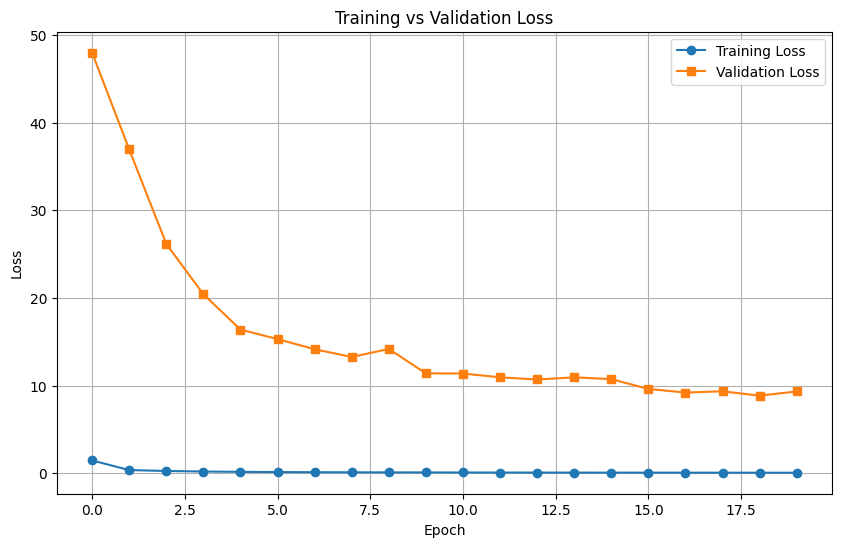

Epoch 1: Train Loss = 2.0951, Val Loss = 48.3640
Epoch 2: Train Loss = 0.5547, Val Loss = 44.1360
Epoch 3: Train Loss = 0.3318, Val Loss = 31.2038
Epoch 4: Train Loss = 0.2479, Val Loss = 24.9107
Epoch 5: Train Loss = 0.1950, Val Loss = 20.2793
Epoch 6: Train Loss = 0.1654, Val Loss = 16.9072
Epoch 7: Train Loss = 0.1428, Val Loss = 16.0225
Epoch 8: Train Loss = 0.1278, Val Loss = 13.8758
Epoch 9: Train Loss = 0.1144, Val Loss = 13.6420
Epoch 10: Train Loss = 0.1056, Val Loss = 12.2188
Epoch 11: Train Loss = 0.0986, Val Loss = 11.4264
Epoch 12: Train Loss = 0.0922, Val Loss = 11.4493
Epoch 13: Train Loss = 0.0844, Val Loss = 10.8029
Epoch 14: Train Loss = 0.0814, Val Loss = 9.5921
Epoch 15: Train Loss = 0.0769, Val Loss = 9.5894
Epoch 16: Train Loss = 0.0734, Val Loss = 8.8658
Epoch 17: Train Loss = 0.0700, Val Loss = 8.8611
Epoch 18: Train Loss = 0.0681, Val Loss = 8.5382
Epoch 19: Train Loss = 0.0637, Val Loss = 8.8173
Epoch 20: Train Loss = 0.0624, Val Loss = 8.6672


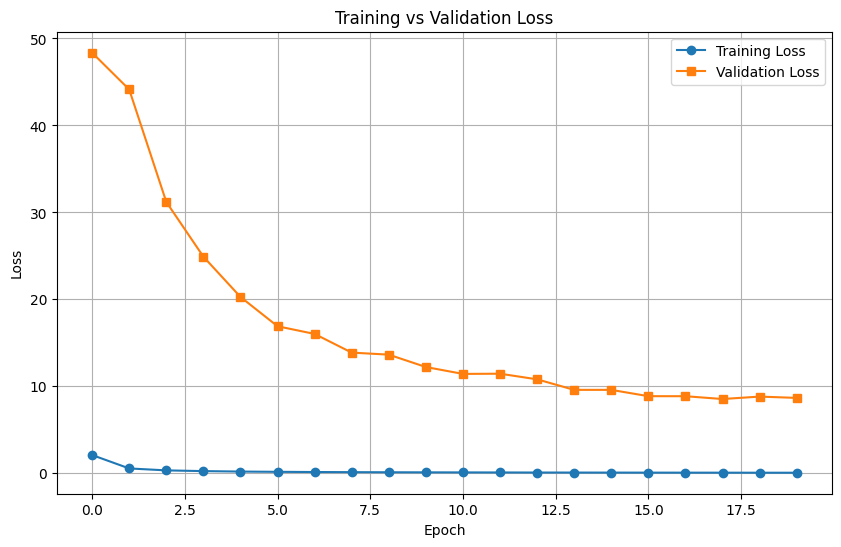

Epoch 1: Train Loss = 1.6322, Val Loss = 46.7715
Epoch 2: Train Loss = 0.4571, Val Loss = 32.0660
Epoch 3: Train Loss = 0.2949, Val Loss = 26.8984
Epoch 4: Train Loss = 0.2254, Val Loss = 21.6402
Epoch 5: Train Loss = 0.1889, Val Loss = 17.8259
Epoch 6: Train Loss = 0.1639, Val Loss = 18.3720
Epoch 7: Train Loss = 0.1509, Val Loss = 14.4392
Epoch 8: Train Loss = 0.1354, Val Loss = 14.0919
Epoch 9: Train Loss = 0.1258, Val Loss = 12.9870
Epoch 10: Train Loss = 0.1213, Val Loss = 11.9600
Epoch 11: Train Loss = 0.1088, Val Loss = 13.2457
Epoch 12: Train Loss = 0.1036, Val Loss = 11.4487
Epoch 13: Train Loss = 0.0989, Val Loss = 11.8356
Epoch 14: Train Loss = 0.0949, Val Loss = 10.7306
Epoch 15: Train Loss = 0.0899, Val Loss = 10.5413
Epoch 16: Train Loss = 0.0853, Val Loss = 9.6086
Epoch 17: Train Loss = 0.0822, Val Loss = 10.1269
Epoch 18: Train Loss = 0.0789, Val Loss = 10.6897
Epoch 19: Train Loss = 0.0784, Val Loss = 9.2980
Epoch 20: Train Loss = 0.0742, Val Loss = 8.8910


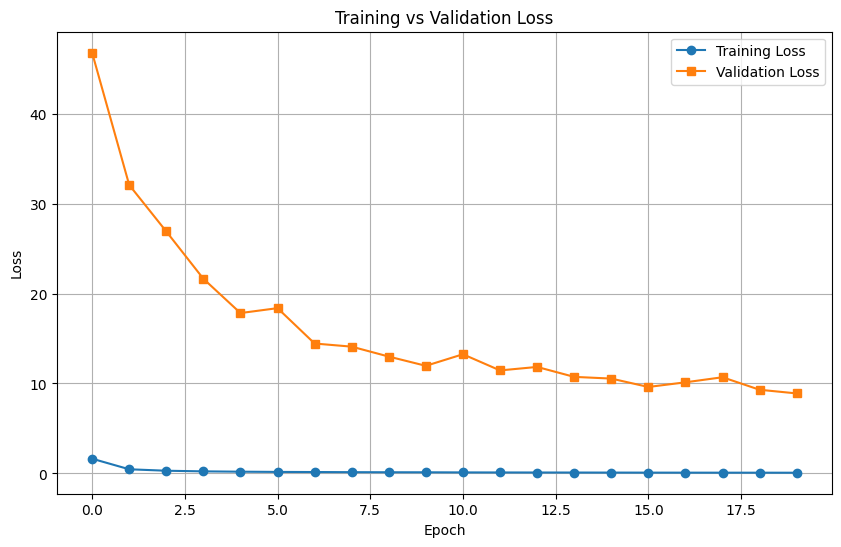

Epoch 1: Train Loss = 2.0290, Val Loss = 53.3462
Epoch 2: Train Loss = 0.7250, Val Loss = 50.4057
Epoch 3: Train Loss = 0.4266, Val Loss = 41.3065
Epoch 4: Train Loss = 0.2947, Val Loss = 32.3756
Epoch 5: Train Loss = 0.2407, Val Loss = 24.6079
Epoch 6: Train Loss = 0.2032, Val Loss = 21.3424
Epoch 7: Train Loss = 0.1795, Val Loss = 20.1610
Epoch 8: Train Loss = 0.1660, Val Loss = 20.5311
Epoch 9: Train Loss = 0.1558, Val Loss = 17.7124
Epoch 10: Train Loss = 0.1437, Val Loss = 19.5076
Epoch 11: Train Loss = 0.1354, Val Loss = 21.0290
Epoch 12: Train Loss = 0.1280, Val Loss = 19.3384
Epoch 13: Train Loss = 0.1234, Val Loss = 19.0387
Epoch 14: Train Loss = 0.1162, Val Loss = 22.1288
Epoch 15: Train Loss = 0.1146, Val Loss = 19.8112
Epoch 16: Train Loss = 0.1073, Val Loss = 18.6900
Epoch 17: Train Loss = 0.1058, Val Loss = 18.9637
Epoch 18: Train Loss = 0.1002, Val Loss = 19.5102
Epoch 19: Train Loss = 0.0974, Val Loss = 19.3063
Epoch 20: Train Loss = 0.0951, Val Loss = 19.7254


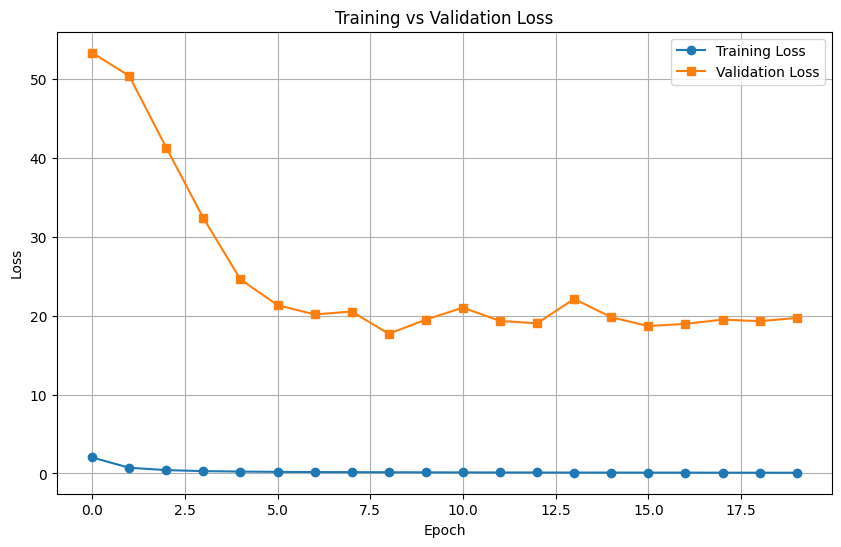

Epoch 1: Train Loss = 2.2306, Val Loss = 20.8082
Epoch 2: Train Loss = 1.0371, Val Loss = 52.6166
Epoch 3: Train Loss = 0.5348, Val Loss = 43.2577
Epoch 4: Train Loss = 0.3828, Val Loss = 40.4659
Epoch 5: Train Loss = 0.3148, Val Loss = 37.9461
Epoch 6: Train Loss = 0.2754, Val Loss = 32.5926
Epoch 7: Train Loss = 0.2469, Val Loss = 30.3802
Epoch 8: Train Loss = 0.2265, Val Loss = 29.0835
Epoch 9: Train Loss = 0.2159, Val Loss = 25.8550
Epoch 10: Train Loss = 0.2058, Val Loss = 26.1826
Epoch 11: Train Loss = 0.1950, Val Loss = 23.9925
Epoch 12: Train Loss = 0.1878, Val Loss = 26.3944
Epoch 13: Train Loss = 0.1762, Val Loss = 26.8501
Epoch 14: Train Loss = 0.1714, Val Loss = 23.8660
Epoch 15: Train Loss = 0.1668, Val Loss = 26.3108
Epoch 16: Train Loss = 0.1615, Val Loss = 20.6728
Epoch 17: Train Loss = 0.1577, Val Loss = 21.4068
Epoch 18: Train Loss = 0.1493, Val Loss = 21.3661
Epoch 19: Train Loss = 0.1479, Val Loss = 20.2175
Epoch 20: Train Loss = 0.1426, Val Loss = 16.8213


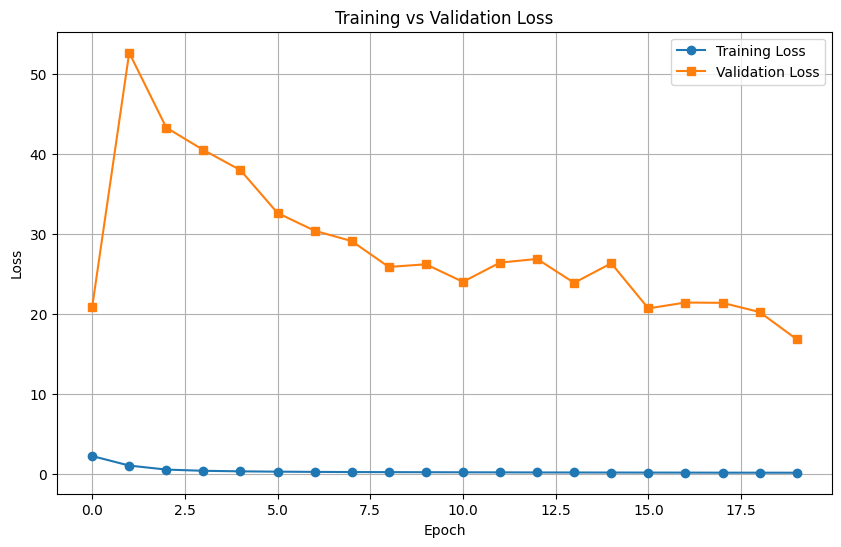

For rate: 0 Accuracy = 98.12857142857143

For rate: 0.1 Accuracy = 98.23571428571428

For rate: 0.3 Accuracy = 98.06428571428572

For rate: 0.5 Accuracy = 96.05714285714286

For rate: 0.7 Accuracy = 96.77142857142857



In [92]:
tuneDropOutRates(modelClass=CNN_dropout)

In [93]:
class CNN_batchNormalization(nn.Module):
    def __init__(self, rate):
        super().__init__()
        self.dropout = nn.Dropout(rate)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.norm1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.maxPool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.norm2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.maxPool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(32 * 5* 5, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self,x):
        x = self.dropout(x)
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.maxPool1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.maxPool2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

Epoch 1: Train Loss = 0.4762, Val Loss = 24.1039
Epoch 2: Train Loss = 0.1293, Val Loss = 31.2791
Epoch 3: Train Loss = 0.0948, Val Loss = 35.9606
Epoch 4: Train Loss = 0.0775, Val Loss = 43.2663


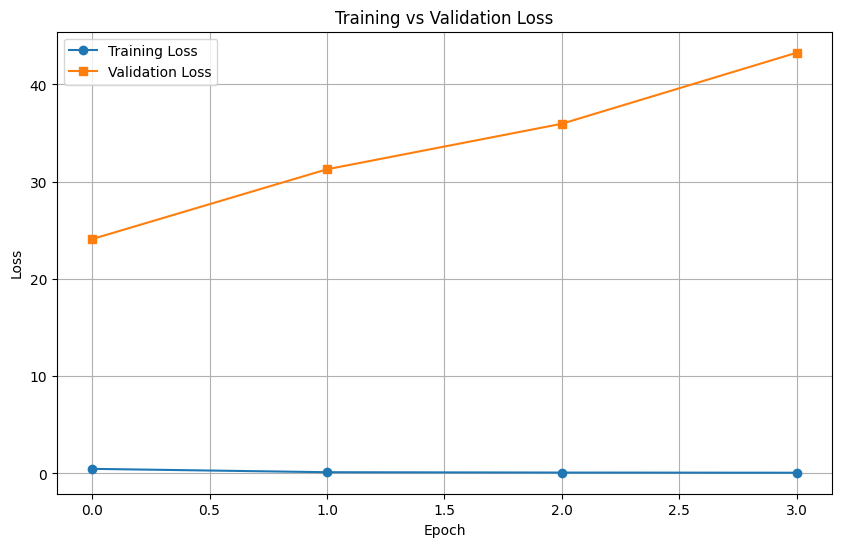

Epoch 1: Train Loss = 0.5807, Val Loss = 26.1323
Epoch 2: Train Loss = 0.1530, Val Loss = 26.4446
Epoch 3: Train Loss = 0.1131, Val Loss = 22.9082
Epoch 4: Train Loss = 0.0945, Val Loss = 25.9406
Epoch 5: Train Loss = 0.0837, Val Loss = 23.4770
Epoch 6: Train Loss = 0.0740, Val Loss = 19.5451
Epoch 7: Train Loss = 0.0677, Val Loss = 16.7466
Epoch 8: Train Loss = 0.0624, Val Loss = 23.0034
Epoch 9: Train Loss = 0.0582, Val Loss = 15.7762
Epoch 10: Train Loss = 0.0546, Val Loss = 16.4097
Epoch 11: Train Loss = 0.0518, Val Loss = 17.4531
Epoch 12: Train Loss = 0.0486, Val Loss = 11.4748
Epoch 13: Train Loss = 0.0471, Val Loss = 19.3538
Epoch 14: Train Loss = 0.0453, Val Loss = 11.1561
Epoch 15: Train Loss = 0.0426, Val Loss = 10.1572
Epoch 16: Train Loss = 0.0414, Val Loss = 13.4308
Epoch 17: Train Loss = 0.0399, Val Loss = 9.2081
Epoch 18: Train Loss = 0.0380, Val Loss = 9.2004
Epoch 19: Train Loss = 0.0360, Val Loss = 9.8385
Epoch 20: Train Loss = 0.0357, Val Loss = 10.7732


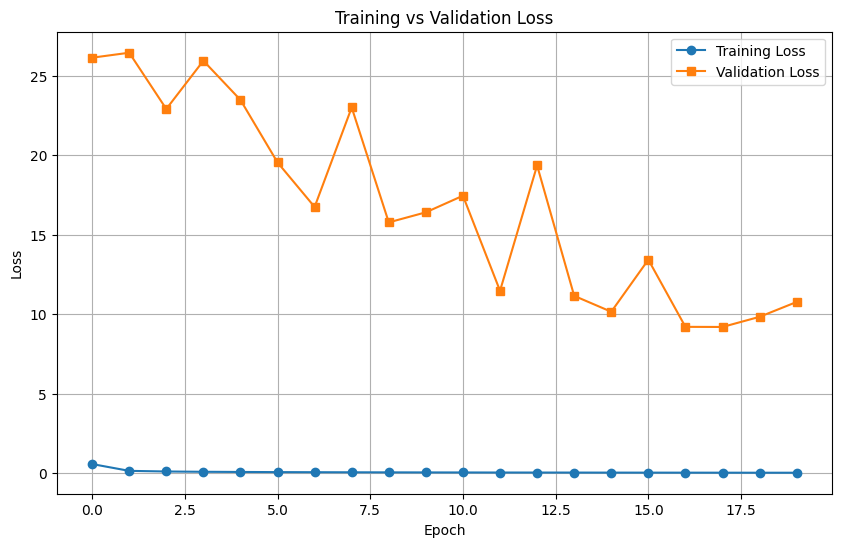

Epoch 1: Train Loss = 0.6609, Val Loss = 20.4075
Epoch 2: Train Loss = 0.2096, Val Loss = 14.5962


In [ ]:
tuneDropOutRates(modelClass=CNN_batchNormalization)
# For rate: 0 Accuracy = 99.12
# For rate: 0.1 Accuracy = 98.94
# For rate: 0.3 Accuracy = 98.74
# For rate: 0.5 Accuracy = 97.62
# For rate: 0.7 Accuracy = 95.84

In [ ]:
model_no_normalization = trainCNN(CNN_dropout(rate=0.3))
model_normalization = trainCNN(CNN_batchNormalization(rate=0.1))
print(evaluateTestCNN(model_no_normalization))
print(evaluateTestCNN(model_normalization))